In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import torch
from model.model_load import load_model
from configs.setting import global_setting

import pandas as pd
import matplotlib.pyplot as plt
from libs import train_utils

In [4]:
config, device = global_setting('cfg.yaml', 'ckpt/sensor-target')
model = load_model(device, config)

In [5]:
checkpoint_path = 'ckpt/sensor-target/LSTM/best.pth'

In [6]:
ckpt = torch.load(checkpoint_path)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [7]:
df = pd.read_excel('res/{}'.format(config['DATA']['FILE_NAME']))

In [8]:
import joblib
scaler_x = 'ckpt/sensor-target/SCALER/x_scaler.pkl'
scaler_y = 'ckpt/sensor-target/SCALER/y_scaler.pkl'
sc_x = joblib.load(scaler_x)
sc_y = joblib.load(scaler_y)

In [9]:
train, valid, test = train_utils.split_dataset(df, config)

In [10]:
input_df=test[config['DATA']['X_COLS']]
target_df = test[config['DATA']['Y_TARGET']]

TARGET = config['DATA']['Y_TARGET']

In [11]:
input_g=df[config['DATA']['X_COLS']]
target_g = df[config['DATA']['Y_TARGET']]

In [12]:
from torch import FloatTensor

xvalue = sc_x.transform(input_df.values)
yvalue = sc_y.transform(target_df.values)

X_tensor = FloatTensor(xvalue)
Y_tensor = FloatTensor(yvalue)

In [13]:
outputs = model(X_tensor)

In [14]:
pred = sc_y.inverse_transform(outputs.float().detach().numpy())
pred_df = pd.DataFrame(pred, columns=config['DATA']['Y_TARGET'])

In [15]:
xv = sc_x.transform(input_g.values)
yv = sc_y.transform(target_g.values)

X_t = FloatTensor(xv)
Y_t = FloatTensor(yv)

In [16]:
op = model(X_t)
pr = sc_y.inverse_transform(op.float().detach().numpy())
pr_df = pd.DataFrame(pr, columns=config['DATA']['Y_TARGET'])

# Accuracy

In [17]:
print('mae', 'mse', 'rmse', 'mape')
print([round(r, 3) for r in train_utils.get_accuracy(outputs, Y_tensor)])
print([round(r, 3) for r in train_utils.get_accuracy_np(pred_df[TARGET].values.ravel(), target_df[TARGET].values.ravel())])

mae mse rmse mape
[0.007, 0.0, 0.019, 82576.75]
[1.203, 9.958, 3.156, 13627769.626]


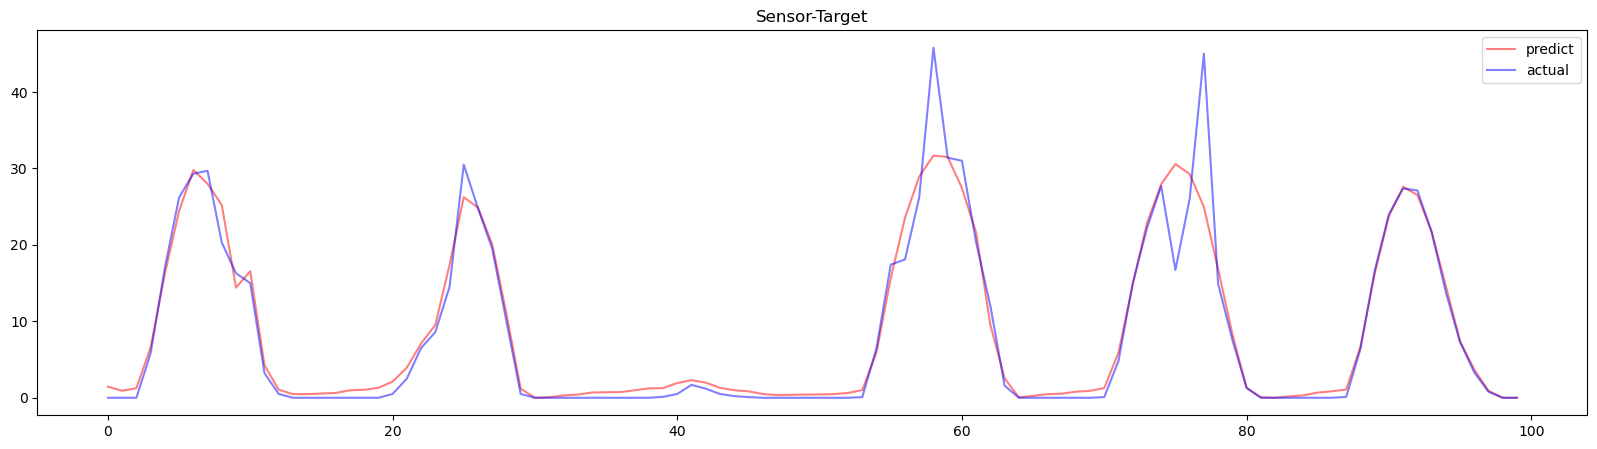

In [19]:
   
fig = plt.figure(figsize=(20, 5))

plt.title('Sensor-Target')
plt.plot(pr_df[TARGET].values.ravel()[:100], color='r', label='predict', alpha=0.5)
plt.plot(target_g[TARGET].values.ravel()[:100], color='b', label='actual', alpha=0.5)
plt.legend()
plt.show()